# Sentiment Analysis Using NLP

In [1]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
 
#NLP libraries
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

#Modeling Packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14,6
plt.style.use("ggplot")

I will be working on a .csv file that contains information about thousands of reviews of the customers.Each review consists of a textual feedback along with a 0 to 4 star rating system( 0 being negative, 4 being positive and 2 being netural).
In this way attributes are available in the data.

1. PhraseID(Numerical) : Sequence of the reviews.
2. SentenceID(Numerical) : Sequence of the words in each phrase
3. Phrase(Text) : Text of the review
4. Sentiment(numerical) : 0 to 4 star rating


The sentiment labels in the dataset are:
1. 0 - negative
2. 1 - somewhat negative
3. 2 - neutral
4. 3 - somewhat positive
5. 4 - positive 

# Reading and Performing basic Analysis of Data

In [2]:
reviews = pd.read_csv('train.csv')

In [3]:
reviews.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


Looking at the distribution of number of words per review. The reviews are already split in number of sentences.Plotting a graph for better visualization

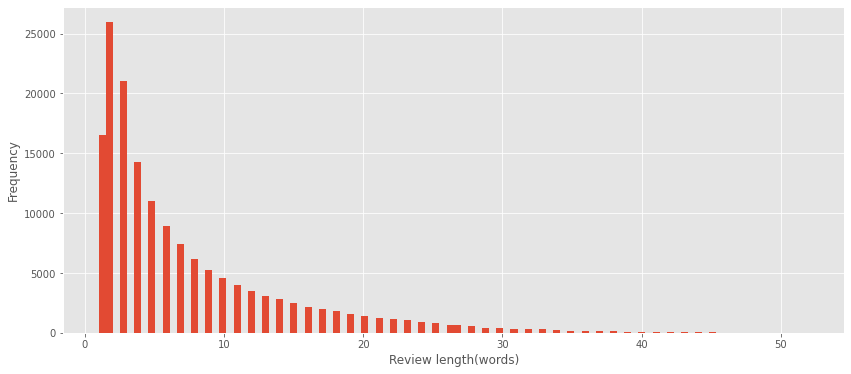

In [4]:
words_per_Phrase = reviews.Phrase.apply(lambda x:len(x.split(" ")))
words_per_Phrase.hist(bins =100)
plt.xlabel("Review length(words)")
plt.ylabel("Frequency")
plt.show()

Maximum of 1 word review is in the phrase which counts of more then 25000 reviews.

In [5]:
print("Average Words : ", words_per_Phrase.mean())
print("skewness:", words_per_Phrase.skew())

Average Words :  7.203376906318082
skewness: 1.8599552100125205


I can see that the number of words per user review is varying between somewhat negative to netural with the mean of 7.2, which means on an average, user review has 7 words.

Now, lets look into the distribution of ratings of sentiment.

In [6]:
percent_val = 100*reviews['Sentiment'].value_counts()/len(reviews)
percent_val

2    50.994489
3    21.098936
1    17.475971
4     5.899013
0     4.531590
Name: Sentiment, dtype: float64

50% of the reviews has netural rating,21% with 3 ratings are somewhat positive,17% with 1 ratings are somewhat negative,5% with 4 rating are positive and 4% with 0 rating are negative.


In short, 50% of the reviews are netural, with only 4% of negative reviews.


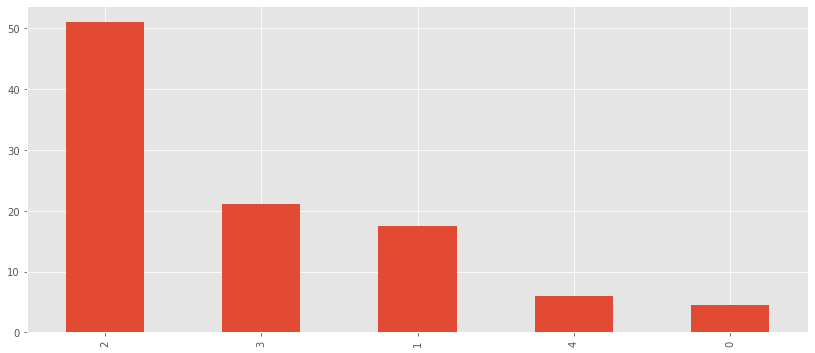

In [7]:
percent_val.plot.bar()
plt.show()

The distribution is quite skewed with more then 50% of 2s and very few 4s and 0s.

# Phrase Visualization using WordCloud

As visualization is important for numerical data, it is also important for phrase(text) data.However, the text doesnot lend itself to histograms charts, scatterplots as numerical data does.
In such cases, word clouds are common and very useful tool for text distribution.

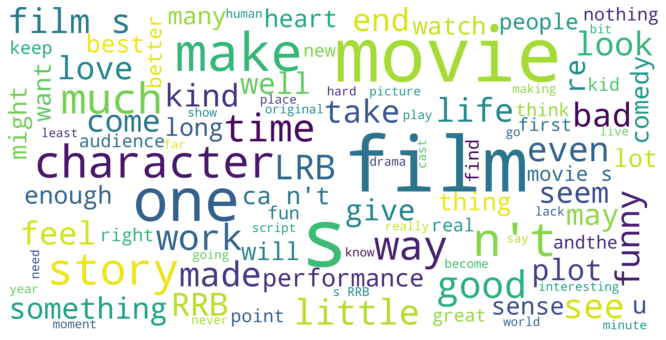

In [8]:
word_cloud_phrase = ''.join(reviews['Phrase'])

wordcloud = WordCloud(max_font_size = 100,#Maximum font size of largest word)
                      max_words = 100, #The Maximum number of words
                      background_color= "white", #background color of the wordcloud image
                      scale = 10, #scaling between computation and drawing
                      width = 800, # width of the canvas
                      height = 400, #height of the canvas
                     ).generate(word_cloud_phrase)
plt.figure()
plt.imshow(wordcloud,
           interpolation='bilinear') #to make the display image appear more smoothly
plt.axis("off")
plt.show()

The word cloud indicated that many of the reviews talk about movie-related stuff like - movie, film, character, performance.We can also see some of the positive words like - good, interesting,funny,better, love as well as not desired ones like bad, never, can't, n't,nothing.


The words which have appeared on the canvas are with the high frequency, the larger the word size the number of times it is used.


Movie,film,make,story, one etc are the words which were used in multiple reviews.
There are few words like S, n't, u,RRB, new which are quite not telling us what this is about, so I'll go with some technique to delete or drop some of the words which are not telling us anything.

# Standardizing the rating of Sentiment Analysis

For the purpose of sentiment analysis, i'll convert all of the ratings to binary values using the following rules.

1. Rating of 3 or 4, i'll get mapped to 1 and will be related to positive reviews.
2. Rating of 0 or 1, i'll get mapped to 0 and will be related to negative reviews.
3. Rating of 2 will be removed since they'll represent netural reviews.

In [9]:
#Mapping the ratings
reviews['Sentiment_Rating'] = np.where(reviews.Sentiment > 2,1,0)

#Removing netual reviews
reviews = reviews[reviews.Sentiment !=2]

#Printing the count of each class
reviews['Sentiment_Rating'].value_counts()

1    42133
0    34345
Name: Sentiment_Rating, dtype: int64

The output here shows positive reviews by 1 which are 42133 reviews, whereas negative reviews are shown by 0 which are 34345, which are quite close.

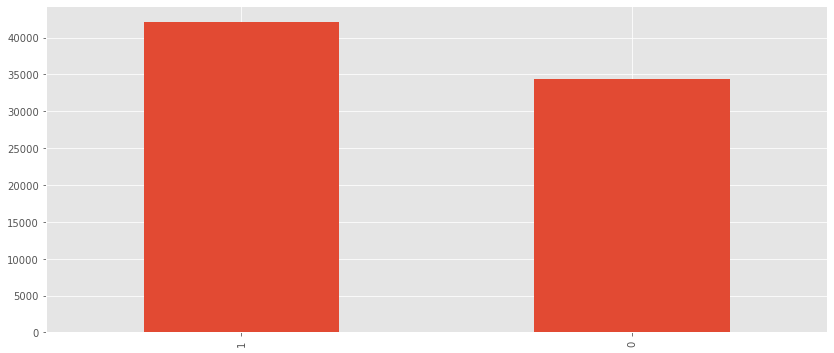

In [10]:
reviews.Sentiment_Rating.value_counts().plot.bar()
plt.show()

There is a class imbalance which we are going to handle by robust metrics

# Pre-Processing

Text processing and normalization is crucial before building a proper NLP model.Some of the steps are:
    
1. Converting words to upper/lower case.
2. Removing special characters.
3. Removing stopwords and high/low frequency words.
4. Stemming/lemmatization

# 1. Converting Words to Upper/lower Case

In [11]:
reviews['review_phrase_new'] = reviews['Phrase'].str.lower()

In the following code cell we analyze the number of unique words that are found in reviews before and after applying this step.
This process of extracting individual words is called "Word Tokenization",and can be run using the "word_tokenize" function in nltk package.

In [12]:
from nltk import word_tokenize

In [13]:
#For reviews not converted to lower case
token_lists = [word_tokenize(each) for each in reviews['Phrase']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ", len(set(tokens)))

#For reviews converted to lower case
token_lists_lower= [word_tokenize(each) for each in reviews['review_phrase_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ", len(set(tokens_lower)))

Number of unique tokens then:  17877
Number of unique tokens now:  16262


The number of tokens have gone down by 9%,just by normalizing the corpus.

Removing special characters is a subjective call, especially in cases like this.People often use special characters to express their emotions and might leave review like "I didn't like this movie!!",while the positive review could be like " I loved this movie, its amazing!!".


Here, presence of exclamation marks clearly indicates something about the underlying sentiment, so removing them is a good idea.
On the other hand, removing non emotionally charged puntuation such as commas, semicolns is likely safe.


# 2. Removing Special characters

I'll proceed by removing all the special characters. The following are the special characters in the dataset.

In [14]:
### selecting all non alpha numeric characters that are not spaces
spl_chars = reviews['review_phrase_new'].apply(lambda review:
                                                  [char for char in list (review) if not char.isalnum() and char != ' '])
## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

#unique special charcaters
set(flat_list)

{'!',
 '#',
 '$',
 '&',
 "'",
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '?',
 '\\',
 '`'}

Lets remove these special characters from the reviews by applying the regular expression:

In [15]:
review_backup = reviews['review_phrase_new'].copy()
reviews['review_phrase_new'] = reviews['review_phrase_new'].str.replace(r'[^A-Za-z0-9]+', ' ')

Lets decompose the regular expression[^A-Za-z0-9]+ :
    
1. [] : Match any character inside the list defined by the square brackets ,including the space character '  '.
2. ^ : Start of the line
3. A-Z : Accept english upper case characters from A to Z
4. a-z : Accept english lower case characters from a to z
5. 0-9 : Accept single numbers from 0 to 9

We can see how review changes after removing these:

In [16]:
print(" - Old Review - ")
print(review_backup.values[157])
print("\n - New Review - ")
print(reviews["review_phrase_new"][157])

 - Old Review - 
, this one is a sweet and modest and ultimately winning story .

 - New Review - 
aggressive self glorification and a manipulative whitewash


The number of unique tokens has dropped further:

# 3. Stopwords and high/low Frequency words

Stopwords naturally occur very frequently in the engligh language without adding any context specific insights.It makes sense to remove them.Let's first review languages available in nltk package:

In [17]:
from nltk.corpus import stopwords

print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


Lets now review the English stopwords

In [18]:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = reviews['review_phrase_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)
        
print("-- Original Sentence --\n",sentence)
print("-- Stopwords in the sentence --\n",stopword)
print("-- Non-stopwords in the sentence --\n",without_stop_words)

-- Original Sentence --
 a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story 
-- Stopwords in the sentence --
 ['a', 'of', 'the', 'that', 'what', 'is', 'for', 'the', 'is', 'for', 'the', 'some', 'of', 'which', 'but', 'of', 'which', 'to', 'of', 'a']
-- Non-stopwords in the sentence --
 ['series', 'escapades', 'demonstrating', 'adage', 'good', 'goose', 'also', 'good', 'gander', 'occasionally', 'amuses', 'none', 'amounts', 'much', 'story']





Lets now omit these stopwords from the reviews

In [20]:
def stopwords_removal(stop_words,sentence):
    return[word for word in nltk.word_tokenize(sentence) if word not in stop_words]
reviews['review_phrase_nonstop'] = reviews["review_phrase_new"].apply(lambda row: stopwords_removal(stop_words,sentence))
reviews[["review_phrase_new","review_phrase_nonstop"]]

,review_phrase_new,review_phrase_nonstop
0,a series of escapades demonstrating the adage ...,"[series, escapades, demonstrating, adage, good..."
21,good for the goose,"[series, escapades, demonstrating, adage, good..."
22,good,"[series, escapades, demonstrating, adage, good..."
33,the gander some of which occasionally amuses b...,"[series, escapades, demonstrating, adage, good..."
46,amuses,"[series, escapades, demonstrating, adage, good..."
...,...,...
156047,quietly suggesting the sadness and obsession b...,"[series, escapades, demonstrating, adage, good..."
156051,sadness and obsession,"[series, escapades, demonstrating, adage, good..."
156052,sadness and,"[series, escapades, demonstrating, adage, good..."
156056,forced avuncular chortles,"[series, escapades, demonstrating, adage, good..."


# 4.Stemming and Lemmatization

Last part of processing is stemming and lemmatization.

1. Stemming : It works by cutting end or beginning of the word,taking into account a list of common prefixes and suffixes that can be found.
2. Lemmatization: It takes into consideration the morphological analyis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting the root word by brute force methods.

In [21]:
from nltk.stem import PorterStemmer,LancasterStemmer #common Stemmers
from nltk.stem import WordNetLemmatizer #common lemmatizer
nltk.download("wordnet")
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizaer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vishakha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Building a machine learning model

Now we have two cleared up versions of two very important pieces of data - the actual review phrase and its corresponding sentiment rating.

In [22]:
reviews[["Phrase", "Sentiment_Rating"]].head(5)

,Phrase,Sentiment_Rating
0,A series of escapades demonstrating the adage ...,0
21,good for the goose,1
22,good,1
33,"the gander , some of which occasionally amuses...",0
46,amuses,1


The independent variables or model features are derived from the review text.

Reading each of the review ,it is clear for the instance ,"good" is mentioned in context like "not so good" or " sounds good".This indicated that in the world of text we can not go by single word, alo called(1-gram).


"n-grams"
Since 1-gram are sometimes insufficient to understand the significance of certain words in our text,it is natural to consider block of words or n-grams.

In [23]:
from nltk import ngrams

# Bag-of-Words

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval.

Lets create a word document co occurance matrix for our set of reviews using the 'CountVectorizer', that automatically accounts for certain preprocessing steps like removing stopwords,stemming, creating ngrams, word tokenization

In [24]:
#Creating word document matrix
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(reviews["review_phrase_new"])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,000,10,100,101,102,103,104,105,10th,11,...,ziyi,zoe,zombie,zone,zoning,zoolander,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lets use this to create bag of words from the reviews, excluding the noise words we identified earlier.

In [25]:
#Creating a python object of class CountVectorizer

bow_counts = CountVectorizer(tokenizer=word_tokenize, #type of tokenizer
                              stop_words=noise_words, #list of stopwords
                              ngram_range=(2,2)) #number of ngrams


bow_data = bow_counts.fit_transform(reviews["review_phrase_new"])

In [26]:
bow_data

<76478x77353 sparse matrix of type '<class 'numpy.int64'>'
	with 597232 stored elements in Compressed Sparse Row format>

I can see that the sparse matrix of 76478 observations(number of rows of review_phrase_new series) has been built and 77353 columns corresponding to the feature extracted by means of represenataion  of 1-gram count of the user review. 

Once the bag of words is prepared, the dataset should be divided into training and tests dataset.

In [27]:
X_train_bow,X_test_bow,y_train_bow,y_test_bow = train_test_split(bow_data, #features
                                                                reviews["Sentiment_Rating"], #target variable
                                                                test_size =0.2, #20% test size
                                                                random_state = 0) #random state for replication purpose

In [28]:
y_test_bow.value_counts()/y_test_bow.shape[0]

1    0.543998
0    0.456002
Name: Sentiment_Rating, dtype: float64

This test data contains 54% positive sentiment reviews.So, if we classify all our reviews positive, then our model would achieve an accuracy of 54%.
This is the baseline that any model we create must beat.We have an imbalance in the classes.However, an intermediate step, techniques, sub sampling or oversampling can be applied.

# Applying Logistic Regression

Let's train the model on our training data and run our resulting model on our test data:

In [29]:
#Traning the model
lr_model_all = LogisticRegression()
lr_model_all.fit(X_train_bow, y_train_bow) #fitting a LR model

#predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bow)  #class prediction

#Calculate key performance metrics
print("F1 Score: ", f1_score(y_test_bow,test_pred_lr_all))

F1 Score:  0.89359752605658


Let's modify the set of features in the model to include bigrams,trigrams, 4-grams.

In [30]:
#change with respect to previos code
##1. Increasing the n-grams from ust having 1-gram to (1-gram,2-gram, 3-gram,4-gram)
##2. Including the stopwords in bag of words features

bow_counts = CountVectorizer(tokenizer=word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(reviews.review_phrase_new)

In [31]:
#notice the increase in features with inclusion ngram
bow_data

<76478x317264 sparse matrix of type '<class 'numpy.int64'>'
	with 2230282 stored elements in Compressed Sparse Row format>

In [32]:
X_train_bow,X_test_bow,y_train_bow,y_test_bow = train_test_split(bow_data, #features
                                                                reviews["Sentiment_Rating"], #target variable
                                                                test_size =0.2, #20% test size
                                                                random_state = 0) #random state for replication purpose

In [33]:
#Defining and training the model

lr_model_all_new = LogisticRegression(max_iter = 200)
lr_model_all_new.fit(X_train_bow, y_train_bow) 


#predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

#Calculate key performance metrics
print("F1 Score: ", f1_score(y_test_bow,test_pred_lr_all))

F1 Score:  0.926878407205499


The F1 score has jumped slightly. This is called as hyperparameter tuning and input features modifiaction can do the overall performance.
We can get interpretable features from this in tearms of what contributed the most of positive and negative sentiment:

In [34]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(),
                                  lr_model_all_new.coef_[0])),
                         columns = ["words","weights"])

lr_weights.sort_values(["weights"], ascending = False)[:15]

,words,weights
87448,entertaining,2.834783
120751,hilarious,2.740879
94488,fascinating,2.731016
44544,beautiful,2.710748
86737,enjoyable,2.664223
111518,good,2.649002
107115,fun,2.612829
51514,brilliant,2.590084
180358,not a bad,2.586802
107428,funny,2.556000


# TF - IDF Model

There is another way to featurise text which is Term Frequency Inverse Document Frequency(TF - IDF) model.
This evaluates how important a word is to a document within a large collection of documents.


Let's re-featurize our original set of reviews based on TF - IDF Model  and split the resulting features into train_test_split:

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_counts = TfidfVectorizer(tokenizer=word_tokenize, #type of tokenizer
                              stop_words=noise_words, #list of stopwords
                              ngram_range=(1,1)) #number of ngrams

tfidf_data = tfidf_counts.fit_transform(reviews["review_phrase_new"])

In [36]:
tfidf_data

<76478x15034 sparse matrix of type '<class 'numpy.float64'>'
	with 643303 stored elements in Compressed Sparse Row format>

In [37]:
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(tfidf_data, #features
                                                                reviews["Sentiment_Rating"], #target variable
                                                                test_size =0.2, #20% test size
                                                                random_state = 0) #random state for replication purpose

# Applying Logistic Regression on TF-IDF features

Let's apply Logistic Regression to the features created on TF-IDF :

In [38]:
lr_model_tf_idf = LogisticRegression()
lr_model_tf_idf.fit(X_train_tfidf, y_train_tfidf) 


#predicting the results
test_pred_tf_idf = lr_model_tf_idf.predict(X_test_tfidf)

#Calculate key performance metrics
print("F1 Score: ", f1_score(y_test_tfidf,test_pred_tf_idf))

F1 Score:  0.8941789542251436


Here, we have decreased slightly our F1 score of TF-IDF as compared to Bag-of-words approach

# Conclusion

In this case, I cleaned up and featurized reviews dataset and built in some classification models on these featurizations to predict sentiment.We saw that bag-of-words and Tf-idf both gave interpretable features.Through increase the set of n-grams we used from 1-gram to 4-gram,we were able to get our logistic regression model 92%.



Building Machine learning models on text is a very involved discipline.Important things of note are as follows:

1. Although there are different types of pre-processingf involved in textual data, not everything has to be applied in each case.
2. Hyperparameter tuning in machine learning is a very important step. We cant go ahead training a model with default parameters.Different sets of parameters have to be ttried to see what contributes to the model is best.
3. Every NLP classification task is different, but the process to be followed is similar to what we did in this case: wrangle the data --> create features from text --> train ML models.